# Face Mask Object Detection using R-CNN

## preparation

In [1]:
from google.colab import drive
drive.mount('/content/googleDrive', force_remount=True)

Mounted at /content/googleDrive


In [2]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

In [3]:
INPUT_BASE_PATH = "/content/googleDrive/My Drive/data"
INPUT_IMAGES = os.path.sep.join([INPUT_BASE_PATH, "images"])
INPUT_ANNOTS = os.path.sep.join([INPUT_BASE_PATH, "annotations"])

OUTPUT_BASE_PATH = "/content/googleDrive/My Drive/data/model"
WITH_MASK_PATH = os.path.sep.join([OUTPUT_BASE_PATH, "mask"])
WITHOUT_MASK_PATH = os.path.sep.join([OUTPUT_BASE_PATH, "no_mask"])
BAD_MASK_PATH = os.path.sep.join([OUTPUT_BASE_PATH, "bad_mask"])

MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

MAX_WITH_MASK = 30
MAX_WITHOTU_MASK = 20
MAX_BAD_MASK = 10

INPUT_DIMS = (224, 224)

MODEL_PATH = "/content/googleDrive/My Drive/data/model/mask_detector_rcnn.h5"
ENCODER_PATH = "/content/googleDrive/My Drive/data/model/label_encoder.pickle"

MIN_PROBA = 0.99


In [4]:
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [5]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [6]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	if len(boxes) == 0:
		return []

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	pick = []

	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	if probs is not None:
		idxs = probs

	idxs = np.argsort(idxs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		overlap = (w * h) / area[idxs[:last]]

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	return pick

## segment new dataset using selective search

In [7]:
# total count
totalWithMask = 0
totalWithoutMask = 0
totalBadMask = 0

In [8]:
# create output directories
for dirPath in (WITH_MASK_PATH, BAD_MASK_PATH, WITHOUT_MASK_PATH):
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

In [9]:
# list of image paths
imagePaths = list(paths.list_images(INPUT_IMAGES))
annotPaths = list(paths.list_files(INPUT_ANNOTS))
print(imagePaths)
print(annotPaths)

[]
[]


In [10]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths)))

    # get corresponding annotation file
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([INPUT_ANNOTS, "{}.xml".format(filename)])

    # read in annotation file
    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    withMaskBoxes = []
    badMaskBoxes = []

    # get dimensions
    width = int(soup.find("width").string)
    height = int(soup.find("height").string)

    # loop over all 'object' elements
    for o in soup.find_all("object"):
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(width, xMax)
        yMax = min(height, yMax)

        if (o.find("name").string == "with_mask"):
            withMaskBoxes.append((xMin, yMin, xMax, yMax))
        elif (o.find("name").string == "mask_weared_incorrect"):
            badMaskBoxes.append((xMin, yMin, xMax, yMax))

    # read image
    image = cv2.imread(imagePath)

    # run selective search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects = []

    # loop over rectangles from search
    for (x, y, w, h) in rects:
        # convert dimensions into boxes
        proposedRects.append((x, y, x + w, y + h))

    # count for each image
    withMaskROIs = 0
    withoutMaskROIs = 0
    badMaskROIs = 0

    # loop over the maximum number of region proposals
    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        # go through boxes for incorrect masks
        for badMaskBox in badMaskBoxes:
            iou = compute_iou(badMaskBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = badMaskBox

            # initialize the ROI and output path
            roi = None
            outputPath = None

            # check for conditions to write 'with_mask'
            if iou > 0.7 and badMaskROIs <= MAX_BAD_MASK:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalBadMask)
                outputPath = os.path.sep.join([BAD_MASK_PATH, filename])

                badMaskROIs += 1
                totalBadMask += 1
            
            # write file
            if roi is not None and outputPath is not None:
                roi = cv2.resize(roi, INPUT_DIMS,
                                 interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

        # go through each boxes
        for withMaskBox in withMaskBoxes:
            iou = compute_iou(withMaskBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = withMaskBox

            # initialize the ROI and output path
            roi = None
            outputPath = None

            # check for conditions to write 'with_mask'
            if iou > 0.7 and withMaskROIs <= MAX_WITH_MASK:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalWithMask)
                outputPath = os.path.sep.join([WITH_MASK_PATH, filename])

                withMaskROIs += 1
                totalWithMask += 1

            # proposed bounding box be in boundaries
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY

            # check for conditions to write 'without_mask'
            if not fullOverlap and iou < 0.05 and withoutMaskROIs <= MAX_WITHOTU_MASK:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalWithoutMask)
                outputPath = os.path.sep.join([WITHOUT_MASK_PATH, filename])

                withoutMaskROIs += 1
                totalWithoutMask += 1

            # write file
            if roi is not None and outputPath is not None:
                roi = cv2.resize(roi, INPUT_DIMS,
                                 interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

## train dataset

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

In [12]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [13]:
def generate_label(string):
    if string == "mask":
        return 1
    elif string == "bad_mask":
        return 2
    return 0

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(OUTPUT_BASE_PATH))
data = []
labels = []

for imagePath in imagePaths:
	image = load_img(imagePath, target_size=INPUT_DIMS)
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(generate_label(imagePath.split(os.path.sep)[-2]))

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

print(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
	class_weight = {0:5 , 1:1, 2:10})

[INFO] training head...
Epoch 1/10
58/58 [==============================] - 91s 2s/step - loss: 1.3448 - accuracy: 0.8197 - val_loss: 0.3118 - val_accuracy: 0.8919
Epoch 2/10
58/58 [==============================] - 90s 2s/step - loss: 0.6866 - accuracy: 0.8915 - val_loss: 0.2555 - val_accuracy: 0.9216
Epoch 3/10
58/58 [==============================] - 90s 2s/step - loss: 0.5319 - accuracy: 0.9114 - val_loss: 0.2060 - val_accuracy: 0.9364
Epoch 4/10
58/58 [==============================] - 91s 2s/step - loss: 0.4616 - accuracy: 0.9266 - val_loss: 0.1966 - val_accuracy: 0.9470
Epoch 5/10
58/58 [==============================] - 91s 2s/step - loss: 0.3835 - accuracy: 0.9347 - val_loss: 0.1673 - val_accuracy: 0.9513
Epoch 6/10
58/58 [==============================] - 96s 2s/step - loss: 0.3137 - accuracy: 0.9411 - val_loss: 0.1362 - val_accuracy: 0.9576
Epoch 7/10
58/58 [==============================] - 91s 2s/step - loss: 0.3129 - accuracy: 0.9438 - val_loss: 0.1140 - val_accuracy: 0.9

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       387
           1       0.99      0.80      0.89        82
           2       1.00      1.00      1.00         3

    accuracy                           0.96       472
   macro avg       0.98      0.93      0.95       472
weighted avg       0.96      0.96      0.96       472



In [ ]:
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving mask detector model...


In [ ]:
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label encoder...


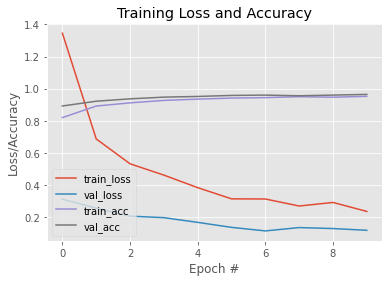

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")